In [1]:
import sys
# sys.path.append("/home/matthias/Documents/EmbeddedAI/deep-microcompression/")
sys.path.append("../../")

from development import (
    Sequential,
    AvgPool2d,
    BatchNorm2d,
    Conv2d,
    Linear,
    ReLU,
    ReLU6,
    MaxPool2d,
    Flatten, 

    EarlyStopper,
    dequantize_per_tensor_sy,
    
    QuantizationGranularity,
    QuantizationScaleType,
    QuantizationScheme
)

/home/matthias/Documents/EmbeddedAI/deep-microcompression/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
import os
import copy
import random

from tqdm.auto import tqdm

import torch
from torch import nn, optim
from torch.utils import data
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
lenet5_file = f"lenet5_state_dict.pth"
log_compression_details_file = "lenet5_compression_log.csv"

hp_deployment_base_dir = "./HP HP Pavilion Laptop 15-cs3xxx/"
hp_src_dir = os.path.join(hp_deployment_base_dir, "src")
hp_include_dir = os.path.join(hp_deployment_base_dir, "include")

arduino_deployment_base_dir = "./Arduino Nano 33 BLE/"
arduino_src_dir = os.path.join(arduino_deployment_base_dir, "src")
arduino_include_dir = os.path.join(arduino_deployment_base_dir, "include")

LUCKY_NUMBER = 25
torch.manual_seed(LUCKY_NUMBER)
torch.random.manual_seed(LUCKY_NUMBER)
torch.cuda.manual_seed(LUCKY_NUMBER)

DEVICE 

'cuda'

In [4]:
input_shape = (1, 28, 28)

data_transform = transforms.Compose([
    transforms.RandomCrop((24, 24)),
    transforms.Resize(input_shape[1:]),
    transforms.ToTensor(),
])

mnist_train_dataset = datasets.MNIST("../../../Datasets/", train=True, download=True, transform=data_transform)
mnist_test_dataset = datasets.MNIST("../../../Datasets/", train=False, download=True, transform=data_transform)

mnist_train_loader = data.DataLoader(mnist_train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count(), drop_last=False)
mnist_test_loader = data.DataLoader(mnist_test_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count(), drop_last=False)

In [5]:
lenet5_model = Sequential(
    Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, pad=tuple([2]*4), bias=False),
    BatchNorm2d(num_features=6),
    ReLU6(),

    MaxPool2d(kernel_size=2, stride=2, padding=0),

    Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True),
    BatchNorm2d(num_features=16),
    ReLU(),
    # ReLU6(),

    MaxPool2d(kernel_size=2, stride=2, padding=0),
    # AvgPool2d(kernel_size=2, stride=2, padding=0),

    Flatten(),
    
    Linear(in_features=16*5*5, out_features=84, bias=False),
    ReLU(),
    Linear(in_features=84, out_features=10, bias=True)
).to(DEVICE)

accuracy_fun = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).sum().item()*100

In [6]:
# lenet5_model = Sequential(
#     Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=5, pad=[2]*4, bias=True),
#     # BatchNorm2d(num_features=3),
#     ReLU(),
#     Conv2d(in_channels=6, out_channels=3, kernel_size=1, stride=1, pad=[0]*4, bias=False),
#     MaxPool2d(kernel_size=2, stride=2, padding=0),
#     Flatten(),
#     Linear(in_features=3*3*3, out_features=84, bias=False),
#     ReLU(),
#     Linear(in_features=84, out_features=10, bias=True)
# ).to(DEVICE)

# accuracy_fun = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).sum().item()

In [7]:
# lenet5_model = Sequential(
    
#     Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=5, pad=[2]*4, bias=True),
#     ReLU(),
#     MaxPool2d(kernel_size=2, stride=2, padding=0),
#     # BatchNorm2d(num_features=3),
#     Flatten(),
#     Linear(in_features=3*3*3, out_features=10, bias=True),
# ).to(DEVICE)

# accuracy_fun = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).sum().item()

In [8]:
try:
    # raise RuntimeError
    lenet5_model.cpu()
    lenet5_model.load_state_dict(torch.load(lenet5_file, weights_only=True), strict=False)
    lenet5_model.to(DEVICE)

except (RuntimeError, FileNotFoundError) as e:
    early_stopper = EarlyStopper(
        metric_name="validation_loss",
        min_valid_diff=1e-7,
        mode="min",
        patience=4,
        restore_best_state_dict=True,
    )

    criterion_fun = nn.CrossEntropyLoss()
    optimizion_fun = optim.Adam(lenet5_model.parameters(), lr=1.e-3)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=2)

    lenet5_model.fit(
        mnist_train_loader, 25, 
        criterion_fun, optimizion_fun, lr_scheduler,
        validation_dataloader=mnist_test_loader, 
        metrics={"acc" : accuracy_fun},
        callbacks=[early_stopper],
        device=DEVICE
    )
    lenet5_model.cpu()
    torch.save(lenet5_model.state_dict(), lenet5_file)
    lenet5_model.to(DEVICE)
    

In [9]:
prune_channel_acc_estimator = lenet5_model.get_nas_prune_channel(input_shape=input_shape, data_loader=mnist_test_loader, metric_fun=accuracy_fun, device=DEVICE, num_data=100)


{'conv2d_0': 2, 'conv2d_1': 2, 'linear_0': 70}


100%|██████████| 313/313 [00:01<00:00, 201.31it/s]


{'conv2d_0': 5, 'conv2d_1': 7, 'linear_0': 36}


100%|██████████| 313/313 [00:01<00:00, 198.41it/s]


{'conv2d_0': 3, 'conv2d_1': 4, 'linear_0': 27}


100%|██████████| 313/313 [00:01<00:00, 170.35it/s]

{'conv2d_0': 4, 'conv2d_1': 1, 'linear_0': 47}



100%|██████████| 313/313 [00:01<00:00, 167.25it/s]


{'conv2d_0': 5, 'conv2d_1': 3, 'linear_0': 34}


100%|██████████| 313/313 [00:01<00:00, 203.42it/s]

{'conv2d_0': 4, 'conv2d_1': 0, 'linear_0': 24}



100%|██████████| 313/313 [00:02<00:00, 143.08it/s]


{'conv2d_0': 2, 'conv2d_1': 6, 'linear_0': 77}


100%|██████████| 313/313 [00:02<00:00, 133.45it/s]


{'conv2d_0': 2, 'conv2d_1': 2, 'linear_0': 54}


100%|██████████| 313/313 [00:02<00:00, 142.16it/s]


{'conv2d_0': 0, 'conv2d_1': 1, 'linear_0': 13}


100%|██████████| 313/313 [00:01<00:00, 183.36it/s]


{'conv2d_0': 4, 'conv2d_1': 8, 'linear_0': 29}


100%|██████████| 313/313 [00:01<00:00, 180.69it/s]


{'conv2d_0': 4, 'conv2d_1': 4, 'linear_0': 77}


100%|██████████| 313/313 [00:01<00:00, 195.54it/s]


{'conv2d_0': 4, 'conv2d_1': 15, 'linear_0': 17}


100%|██████████| 313/313 [00:01<00:00, 181.59it/s]


{'conv2d_0': 4, 'conv2d_1': 5, 'linear_0': 8}


100%|██████████| 313/313 [00:01<00:00, 164.56it/s]


{'conv2d_0': 2, 'conv2d_1': 13, 'linear_0': 39}


100%|██████████| 313/313 [00:01<00:00, 191.04it/s]


{'conv2d_0': 4, 'conv2d_1': 9, 'linear_0': 58}


100%|██████████| 313/313 [00:01<00:00, 181.83it/s]


{'conv2d_0': 5, 'conv2d_1': 9, 'linear_0': 1}


100%|██████████| 313/313 [00:01<00:00, 206.37it/s]


{'conv2d_0': 3, 'conv2d_1': 8, 'linear_0': 7}


100%|██████████| 313/313 [00:01<00:00, 203.57it/s]


{'conv2d_0': 0, 'conv2d_1': 1, 'linear_0': 59}


100%|██████████| 313/313 [00:01<00:00, 209.57it/s]


{'conv2d_0': 5, 'conv2d_1': 2, 'linear_0': 37}


100%|██████████| 313/313 [00:01<00:00, 196.28it/s]


{'conv2d_0': 0, 'conv2d_1': 6, 'linear_0': 56}


100%|██████████| 313/313 [00:01<00:00, 176.58it/s]


{'conv2d_0': 2, 'conv2d_1': 3, 'linear_0': 6}


100%|██████████| 313/313 [00:01<00:00, 188.77it/s]

{'conv2d_0': 1, 'conv2d_1': 14, 'linear_0': 18}



100%|██████████| 313/313 [00:01<00:00, 214.82it/s]


{'conv2d_0': 0, 'conv2d_1': 15, 'linear_0': 40}


100%|██████████| 313/313 [00:01<00:00, 207.20it/s]


{'conv2d_0': 4, 'conv2d_1': 3, 'linear_0': 7}


100%|██████████| 313/313 [00:01<00:00, 225.94it/s]


{'conv2d_0': 5, 'conv2d_1': 6, 'linear_0': 62}


100%|██████████| 313/313 [00:01<00:00, 225.63it/s]


{'conv2d_0': 5, 'conv2d_1': 9, 'linear_0': 26}


100%|██████████| 313/313 [00:01<00:00, 191.58it/s]


{'conv2d_0': 0, 'conv2d_1': 10, 'linear_0': 6}


100%|██████████| 313/313 [00:01<00:00, 206.85it/s]


{'conv2d_0': 4, 'conv2d_1': 13, 'linear_0': 32}


100%|██████████| 313/313 [00:01<00:00, 209.11it/s]


{'conv2d_0': 4, 'conv2d_1': 0, 'linear_0': 66}


100%|██████████| 313/313 [00:01<00:00, 201.94it/s]


{'conv2d_0': 3, 'conv2d_1': 13, 'linear_0': 75}


100%|██████████| 313/313 [00:01<00:00, 208.80it/s]


{'conv2d_0': 2, 'conv2d_1': 7, 'linear_0': 7}


100%|██████████| 313/313 [00:02<00:00, 149.63it/s]


{'conv2d_0': 1, 'conv2d_1': 1, 'linear_0': 9}


100%|██████████| 313/313 [00:02<00:00, 131.85it/s]


{'conv2d_0': 0, 'conv2d_1': 6, 'linear_0': 82}


100%|██████████| 313/313 [00:01<00:00, 193.46it/s]


{'conv2d_0': 3, 'conv2d_1': 14, 'linear_0': 49}


100%|██████████| 313/313 [00:01<00:00, 199.71it/s]


{'conv2d_0': 1, 'conv2d_1': 14, 'linear_0': 38}


100%|██████████| 313/313 [00:01<00:00, 211.98it/s]

{'conv2d_0': 3, 'conv2d_1': 14, 'linear_0': 29}



100%|██████████| 313/313 [00:01<00:00, 217.01it/s]


{'conv2d_0': 1, 'conv2d_1': 11, 'linear_0': 74}


100%|██████████| 313/313 [00:01<00:00, 197.97it/s]


{'conv2d_0': 0, 'conv2d_1': 4, 'linear_0': 51}


100%|██████████| 313/313 [00:01<00:00, 193.06it/s]


{'conv2d_0': 0, 'conv2d_1': 0, 'linear_0': 10}


100%|██████████| 313/313 [00:01<00:00, 178.39it/s]


{'conv2d_0': 0, 'conv2d_1': 1, 'linear_0': 41}


100%|██████████| 313/313 [00:02<00:00, 150.12it/s]

{'conv2d_0': 0, 'conv2d_1': 5, 'linear_0': 19}



100%|██████████| 313/313 [00:01<00:00, 158.66it/s]


{'conv2d_0': 4, 'conv2d_1': 0, 'linear_0': 14}


100%|██████████| 313/313 [00:01<00:00, 193.95it/s]


{'conv2d_0': 4, 'conv2d_1': 3, 'linear_0': 58}


100%|██████████| 313/313 [00:01<00:00, 202.32it/s]

{'conv2d_0': 3, 'conv2d_1': 6, 'linear_0': 61}



100%|██████████| 313/313 [00:01<00:00, 197.40it/s]


{'conv2d_0': 0, 'conv2d_1': 14, 'linear_0': 46}


100%|██████████| 313/313 [00:01<00:00, 184.11it/s]


{'conv2d_0': 1, 'conv2d_1': 10, 'linear_0': 30}


100%|██████████| 313/313 [00:01<00:00, 157.92it/s]


{'conv2d_0': 2, 'conv2d_1': 6, 'linear_0': 48}


100%|██████████| 313/313 [00:01<00:00, 211.94it/s]


{'conv2d_0': 3, 'conv2d_1': 7, 'linear_0': 28}


100%|██████████| 313/313 [00:01<00:00, 224.88it/s]


{'conv2d_0': 4, 'conv2d_1': 0, 'linear_0': 27}


100%|██████████| 313/313 [00:01<00:00, 231.63it/s]


{'conv2d_0': 3, 'conv2d_1': 7, 'linear_0': 70}


100%|██████████| 313/313 [00:01<00:00, 231.41it/s]


{'conv2d_0': 3, 'conv2d_1': 6, 'linear_0': 82}


100%|██████████| 313/313 [00:01<00:00, 186.38it/s]


{'conv2d_0': 0, 'conv2d_1': 15, 'linear_0': 31}


100%|██████████| 313/313 [00:01<00:00, 193.19it/s]


{'conv2d_0': 5, 'conv2d_1': 0, 'linear_0': 80}


100%|██████████| 313/313 [00:02<00:00, 148.27it/s]


{'conv2d_0': 2, 'conv2d_1': 10, 'linear_0': 39}


100%|██████████| 313/313 [00:01<00:00, 182.41it/s]


{'conv2d_0': 4, 'conv2d_1': 5, 'linear_0': 54}


100%|██████████| 313/313 [00:01<00:00, 178.16it/s]

{'conv2d_0': 1, 'conv2d_1': 9, 'linear_0': 25}



100%|██████████| 313/313 [00:01<00:00, 181.80it/s]


{'conv2d_0': 4, 'conv2d_1': 6, 'linear_0': 16}


100%|██████████| 313/313 [00:01<00:00, 174.15it/s]


{'conv2d_0': 2, 'conv2d_1': 15, 'linear_0': 37}


100%|██████████| 313/313 [00:01<00:00, 194.51it/s]


{'conv2d_0': 1, 'conv2d_1': 4, 'linear_0': 12}


100%|██████████| 313/313 [00:01<00:00, 185.05it/s]

{'conv2d_0': 0, 'conv2d_1': 4, 'linear_0': 81}



100%|██████████| 313/313 [00:01<00:00, 203.38it/s]

{'conv2d_0': 0, 'conv2d_1': 7, 'linear_0': 73}



100%|██████████| 313/313 [00:01<00:00, 206.31it/s]


{'conv2d_0': 0, 'conv2d_1': 11, 'linear_0': 16}


100%|██████████| 313/313 [00:01<00:00, 203.40it/s]


{'conv2d_0': 3, 'conv2d_1': 7, 'linear_0': 8}


100%|██████████| 313/313 [00:01<00:00, 207.52it/s]


{'conv2d_0': 3, 'conv2d_1': 14, 'linear_0': 53}


100%|██████████| 313/313 [00:01<00:00, 168.48it/s]

{'conv2d_0': 5, 'conv2d_1': 7, 'linear_0': 54}



100%|██████████| 313/313 [00:01<00:00, 165.64it/s]


{'conv2d_0': 4, 'conv2d_1': 13, 'linear_0': 61}


100%|██████████| 313/313 [00:02<00:00, 151.51it/s]


{'conv2d_0': 5, 'conv2d_1': 14, 'linear_0': 75}


100%|██████████| 313/313 [00:01<00:00, 195.14it/s]


{'conv2d_0': 2, 'conv2d_1': 11, 'linear_0': 61}


100%|██████████| 313/313 [00:01<00:00, 204.27it/s]


{'conv2d_0': 2, 'conv2d_1': 9, 'linear_0': 41}


100%|██████████| 313/313 [00:01<00:00, 202.34it/s]

{'conv2d_0': 3, 'conv2d_1': 14, 'linear_0': 48}



100%|██████████| 313/313 [00:01<00:00, 212.16it/s]


{'conv2d_0': 0, 'conv2d_1': 9, 'linear_0': 30}


100%|██████████| 313/313 [00:01<00:00, 201.10it/s]


{'conv2d_0': 5, 'conv2d_1': 8, 'linear_0': 52}


100%|██████████| 313/313 [00:01<00:00, 206.64it/s]


{'conv2d_0': 0, 'conv2d_1': 13, 'linear_0': 32}


100%|██████████| 313/313 [00:01<00:00, 201.89it/s]

{'conv2d_0': 3, 'conv2d_1': 14, 'linear_0': 20}



100%|██████████| 313/313 [00:01<00:00, 207.23it/s]


{'conv2d_0': 5, 'conv2d_1': 15, 'linear_0': 60}


100%|██████████| 313/313 [00:01<00:00, 201.50it/s]

{'conv2d_0': 3, 'conv2d_1': 15, 'linear_0': 30}



100%|██████████| 313/313 [00:01<00:00, 204.45it/s]


{'conv2d_0': 3, 'conv2d_1': 13, 'linear_0': 27}


100%|██████████| 313/313 [00:01<00:00, 194.75it/s]


{'conv2d_0': 0, 'conv2d_1': 11, 'linear_0': 44}


100%|██████████| 313/313 [00:01<00:00, 204.73it/s]


{'conv2d_0': 0, 'conv2d_1': 5, 'linear_0': 56}


100%|██████████| 313/313 [00:01<00:00, 201.62it/s]

{'conv2d_0': 0, 'conv2d_1': 5, 'linear_0': 41}



100%|██████████| 313/313 [00:01<00:00, 206.95it/s]


{'conv2d_0': 3, 'conv2d_1': 3, 'linear_0': 46}


100%|██████████| 313/313 [00:01<00:00, 202.48it/s]

{'conv2d_0': 5, 'conv2d_1': 3, 'linear_0': 5}



100%|██████████| 313/313 [00:01<00:00, 192.98it/s]


{'conv2d_0': 3, 'conv2d_1': 0, 'linear_0': 45}


100%|██████████| 313/313 [00:01<00:00, 204.93it/s]


{'conv2d_0': 1, 'conv2d_1': 14, 'linear_0': 60}


100%|██████████| 313/313 [00:01<00:00, 202.97it/s]

{'conv2d_0': 3, 'conv2d_1': 0, 'linear_0': 33}



100%|██████████| 313/313 [00:01<00:00, 190.09it/s]


{'conv2d_0': 3, 'conv2d_1': 5, 'linear_0': 2}


100%|██████████| 313/313 [00:01<00:00, 205.73it/s]


{'conv2d_0': 5, 'conv2d_1': 5, 'linear_0': 81}


100%|██████████| 313/313 [00:01<00:00, 205.58it/s]

{'conv2d_0': 2, 'conv2d_1': 2, 'linear_0': 65}



100%|██████████| 313/313 [00:01<00:00, 200.92it/s]

{'conv2d_0': 3, 'conv2d_1': 1, 'linear_0': 25}



100%|██████████| 313/313 [00:01<00:00, 202.30it/s]

{'conv2d_0': 4, 'conv2d_1': 0, 'linear_0': 30}



100%|██████████| 313/313 [00:01<00:00, 205.12it/s]


{'conv2d_0': 3, 'conv2d_1': 6, 'linear_0': 45}


100%|██████████| 313/313 [00:01<00:00, 201.57it/s]

{'conv2d_0': 3, 'conv2d_1': 14, 'linear_0': 2}



100%|██████████| 313/313 [00:01<00:00, 163.86it/s]


{'conv2d_0': 5, 'conv2d_1': 0, 'linear_0': 33}


100%|██████████| 313/313 [00:01<00:00, 187.32it/s]


{'conv2d_0': 4, 'conv2d_1': 2, 'linear_0': 17}


100%|██████████| 313/313 [00:01<00:00, 196.03it/s]

{'conv2d_0': 1, 'conv2d_1': 2, 'linear_0': 13}



100%|██████████| 313/313 [00:01<00:00, 200.07it/s]


{'conv2d_0': 3, 'conv2d_1': 15, 'linear_0': 47}


100%|██████████| 313/313 [00:01<00:00, 191.62it/s]


{'conv2d_0': 0, 'conv2d_1': 8, 'linear_0': 6}


100%|██████████| 313/313 [00:01<00:00, 201.83it/s]


{'conv2d_0': 1, 'conv2d_1': 8, 'linear_0': 33}


100%|██████████| 313/313 [00:01<00:00, 201.87it/s]


{'conv2d_0': 5, 'conv2d_1': 7, 'linear_0': 18}


100%|██████████| 313/313 [00:01<00:00, 202.69it/s]

{'conv2d_0': 3, 'conv2d_1': 9, 'linear_0': 61}



100%|██████████| 313/313 [00:01<00:00, 201.61it/s]


100 80 torch.Size([100, 1])
tensor([18, 86, 75, 36, 48,  2, 45, 22, 50, 25, 67, 89, 96, 72, 26, 16, 34, 64,
        38, 98, 71, 92, 44, 41, 84, 19, 60,  1, 80, 62, 93, 91, 37,  4, 70, 79,
        13, 74, 43, 52,  5, 28, 24, 35, 49, 83, 14, 12, 56, 53, 76, 23,  7, 63,
        51, 33, 73, 78, 95, 77, 31, 27, 55, 82,  8, 29, 20,  0, 61, 65, 97, 42,
        21, 68, 66, 47, 88, 17, 58, 87]) tensor([94,  6, 39, 40, 46, 11, 57, 32,  3, 30, 10, 85, 99,  9, 90, 59, 81, 69,
        54, 15])


  1%|          | 1/100 [00:00<00:11,  8.63it/s]

epoch    0 | train loss 88.5253 | validation loss 46.1973 | train mse 88.5253 | validation mse 46.1973


100%|██████████| 2/2 [00:00<00:00, 876.00it/s]


epoch    1 | train loss 88.2680 | validation loss 46.8986 | train mse 88.2681 | validation mse 46.8986


100%|██████████| 2/2 [00:00<00:00, 603.76it/s]


epoch    2 | train loss 88.0059 | validation loss 50.4367 | train mse 88.0059 | validation mse 50.4367


100%|██████████| 2/2 [00:00<00:00, 656.69it/s]


epoch    3 | train loss 87.7401 | validation loss 42.3308 | train mse 87.7401 | validation mse 42.3308


100%|██████████| 2/2 [00:00<00:00, 519.32it/s]


epoch    4 | train loss 87.4729 | validation loss 49.9823 | train mse 87.4730 | validation mse 49.9823


100%|██████████| 2/2 [00:00<00:00, 380.47it/s]


epoch    5 | train loss 87.1978 | validation loss 44.4643 | train mse 87.1978 | validation mse 44.4643


100%|██████████| 2/2 [00:00<00:00, 329.52it/s]

epoch    6 | train loss 86.9170 | validation loss 42.6561 | train mse 86.9170 | validation mse 42.6561



100%|██████████| 2/2 [00:00<00:00, 429.52it/s]


epoch    7 | train loss 86.6312 | validation loss 49.9826 | train mse 86.6312 | validation mse 49.9826


  9%|▉         | 9/100 [00:00<00:01, 46.20it/s]

epoch    8 | train loss 86.3373 | validation loss 39.2676 | train mse 86.3373 | validation mse 39.2676


100%|██████████| 2/2 [00:00<00:00, 404.09it/s]


epoch    9 | train loss 86.0317 | validation loss 37.9405 | train mse 86.0317 | validation mse 37.9405


100%|██████████| 2/2 [00:00<00:00, 460.33it/s]


epoch   10 | train loss 85.7148 | validation loss 57.7218 | train mse 85.7148 | validation mse 57.7218


100%|██████████| 2/2 [00:00<00:00, 547.45it/s]


epoch   11 | train loss 85.3881 | validation loss 46.2980 | train mse 85.3881 | validation mse 46.2980


100%|██████████| 2/2 [00:00<00:00, 331.19it/s]


epoch   12 | train loss 85.0477 | validation loss 48.7943 | train mse 85.0477 | validation mse 48.7943


100%|██████████| 2/2 [00:00<00:00, 383.80it/s]


epoch   13 | train loss 84.6943 | validation loss 37.0789 | train mse 84.6943 | validation mse 37.0789


100%|██████████| 2/2 [00:00<00:00, 527.59it/s]


epoch   14 | train loss 84.3265 | validation loss 51.3448 | train mse 84.3265 | validation mse 51.3448


 16%|█▌        | 16/100 [00:00<00:01, 53.31it/s]

epoch   15 | train loss 83.9445 | validation loss 47.4171 | train mse 83.9445 | validation mse 47.4171


100%|██████████| 2/2 [00:00<00:00, 596.80it/s]


epoch   16 | train loss 83.5473 | validation loss 44.0589 | train mse 83.5473 | validation mse 44.0589


100%|██████████| 2/2 [00:00<00:00, 417.09it/s]


epoch   17 | train loss 83.1356 | validation loss 39.9394 | train mse 83.1356 | validation mse 39.9394


100%|██████████| 2/2 [00:00<00:00, 684.00it/s]


epoch   18 | train loss 82.7087 | validation loss 43.9300 | train mse 82.7087 | validation mse 43.9300


100%|██████████| 2/2 [00:00<00:00, 428.71it/s]


epoch   19 | train loss 82.2655 | validation loss 40.5801 | train mse 82.2655 | validation mse 40.5801


100%|██████████| 2/2 [00:00<00:00, 756.21it/s]


epoch   20 | train loss 81.8045 | validation loss 33.8633 | train mse 81.8045 | validation mse 33.8633


100%|██████████| 2/2 [00:00<00:00, 788.33it/s]


epoch   21 | train loss 81.3269 | validation loss 46.0241 | train mse 81.3269 | validation mse 46.0241


100%|██████████| 2/2 [00:00<00:00, 313.41it/s]


epoch   22 | train loss 80.8329 | validation loss 50.8270 | train mse 80.8329 | validation mse 50.8270


 24%|██▍       | 24/100 [00:00<00:01, 59.01it/s]

epoch   23 | train loss 80.3204 | validation loss 37.7650 | train mse 80.3204 | validation mse 37.7650


100%|██████████| 2/2 [00:00<00:00, 397.83it/s]


epoch   24 | train loss 79.7905 | validation loss 40.3139 | train mse 79.7905 | validation mse 40.3139


100%|██████████| 2/2 [00:00<00:00, 330.07it/s]


epoch   25 | train loss 79.2433 | validation loss 37.3051 | train mse 79.2433 | validation mse 37.3051


100%|██████████| 2/2 [00:00<00:00, 339.69it/s]

epoch   26 | train loss 78.6787 | validation loss 43.5458

 | train mse 78.6787 | validation mse 43.5458


100%|██████████| 2/2 [00:00<00:00, 375.65it/s]


epoch   27 | train loss 78.0966 | validation loss 39.6182 | train mse 78.0966 | validation mse 39.6182


100%|██████████| 2/2 [00:00<00:00, 276.67it/s]


epoch   28 | train loss 77.4963 | validation loss 38.8234 | train mse 77.4963 | validation mse 38.8234


 30%|███       | 30/100 [00:00<00:01, 54.55it/s]

epoch   29 | train loss 76.8781 | validation loss 47.5543 | train mse 76.8781 | validation mse 47.5543


100%|██████████| 2/2 [00:00<00:00, 505.73it/s]


epoch   30 | train loss 76.2416 | validation loss 38.4446 | train mse 76.2416 | validation mse 38.4446


100%|██████████| 2/2 [00:00<00:00, 234.60it/s]


epoch   31 | train loss 75.5869 | validation loss 33.7212 | train mse 75.5869 | validation mse 33.7212


100%|██████████| 2/2 [00:00<00:00, 343.20it/s]


epoch   32 | train loss 74.9140 | validation loss 45.8629 | train mse 74.9140 | validation mse 45.8629


100%|██████████| 2/2 [00:00<00:00, 388.06it/s]


epoch   33 | train loss 74.2228 | validation loss 30.2216 | train mse 74.2228 | validation mse 30.2216


100%|██████████| 2/2 [00:00<00:00, 362.61it/s]


epoch   34 | train loss 73.5135 | validation loss 45.7646 | train mse 73.5135 | validation mse 45.7646


 36%|███▌      | 36/100 [00:00<00:01, 53.55it/s]

epoch   35 | train loss 72.7860 | validation loss 50.5187 | train mse 72.7860 | validation mse 50.5187


100%|██████████| 2/2 [00:00<00:00, 417.36it/s]


epoch   36 | train loss 72.0408 | validation loss 39.2880 | train mse 72.0408 | validation mse 39.2880


100%|██████████| 2/2 [00:00<00:00, 610.57it/s]


epoch   37 | train loss 71.2784 | validation loss 35.3538 | train mse 71.2784 | validation mse 35.3538


100%|██████████| 2/2 [00:00<00:00, 203.78it/s]


epoch   38 | train loss 70.4986 | validation loss 39.4989 | train mse 70.4986 | validation mse 39.4989


100%|██████████| 2/2 [00:00<00:00, 404.86it/s]


epoch   39 | train loss 69.7016 | validation loss 39.1787 | train mse 69.7016 | validation mse 39.1787


100%|██████████| 2/2 [00:00<00:00, 447.20it/s]


epoch   40 | train loss 68.8883 | validation loss 32.7229 | train mse 68.8883 | validation mse 32.7229


 42%|████▏     | 42/100 [00:00<00:01, 55.15it/s]

epoch   41 | train loss 68.0582 | validation loss 44.2267 | train mse 68.0582 | validation mse 44.2267


100%|██████████| 2/2 [00:00<00:00, 461.29it/s]


epoch   42 | train loss 67.2125 | validation loss 48.2078 | train mse 67.2125 | validation mse 48.2078


100%|██████████| 2/2 [00:00<00:00, 433.27it/s]


epoch   43 | train loss 66.3511 | validation loss 31.7008 | train mse 66.3511 | validation mse 31.7008


100%|██████████| 2/2 [00:00<00:00, 453.56it/s]

epoch   44 | train loss 65.4752 | validation loss 33.9391 | train mse 65.4752 | validation mse 33.9391



100%|██████████| 2/2 [00:00<00:00, 361.55it/s]


epoch   45 | train loss 64.5851 | validation loss 36.0367 | train mse 64.5851 | validation mse 36.0367


100%|██████████| 2/2 [00:00<00:00, 414.07it/s]


epoch   46 | train loss 63.6816 | validation loss 35.3341 | train mse 63.6816 | validation mse 35.3341


 48%|████▊     | 48/100 [00:00<00:00, 54.51it/s]

epoch   47 | train loss 62.7660 | validation loss 36.2132 | train mse 62.7660 | validation mse 36.2132


100%|██████████| 2/2 [00:00<00:00, 279.03it/s]


epoch   48 | train loss 61.8391 | validation loss 29.2053 | train mse 61.8391 | validation mse 29.2053


100%|██████████| 2/2 [00:00<00:00, 509.26it/s]


epoch   49 | train loss 60.9018 | validation loss 25.6012 | train mse 60.9018 | validation mse 25.6012


100%|██████████| 2/2 [00:00<00:00, 545.03it/s]


epoch   50 | train loss 59.9549 | validation loss 32.4678 | train mse 59.9549 | validation mse 32.4678


100%|██████████| 2/2 [00:00<00:00, 462.34it/s]


epoch   51 | train loss 58.9985 | validation loss 33.1218 | train mse 58.9985 | validation mse 33.1218


100%|██████████| 2/2 [00:00<00:00, 467.49it/s]


epoch   52 | train loss 58.0344 | validation loss 28.3726 | train mse 58.0344 | validation mse 28.3726


100%|██████████| 2/2 [00:00<00:00, 637.58it/s]


epoch   53 | train loss 57.0638 | validation loss 28.2380 | train mse 57.0638 | validation mse 28.2380


 55%|█████▌    | 55/100 [00:01<00:00, 56.60it/s]

epoch   54 | train loss 56.0879 | validation loss 24.1819 | train mse 56.0879 | validation mse 24.1819


100%|██████████| 2/2 [00:00<00:00, 513.35it/s]


epoch   55 | train loss 55.1072 | validation loss 28.2334 | train mse 55.1072 | validation mse 28.2334


100%|██████████| 2/2 [00:00<00:00, 353.23it/s]


epoch   56 | train loss 54.1235 | validation loss 30.5699 | train mse 54.1235 | validation mse 30.5699


100%|██████████| 2/2 [00:00<00:00, 288.91it/s]


epoch   57 | train loss 53.1369 | validation loss 27.0914 | train mse 53.1369 | validation mse 27.0914


100%|██████████| 2/2 [00:00<00:00, 553.85it/s]


epoch   58 | train loss 52.1493 | validation loss 22.5732 | train mse 52.1493 | validation mse 22.5732


100%|██████████| 2/2 [00:00<00:00, 582.46it/s]


epoch   59 | train loss 51.1610 | validation loss 26.6479 | train mse 51.1610 | validation mse 26.6479


 61%|██████    | 61/100 [00:01<00:00, 57.56it/s]

epoch   60 | train loss 50.1742 | validation loss 27.5082 | train mse 50.1742 | validation mse 27.5082


100%|██████████| 2/2 [00:00<00:00, 341.14it/s]


epoch   61 | train loss 49.1901 | validation loss 26.1191 | train mse 49.1901 | validation mse 26.1191


100%|██████████| 2/2 [00:00<00:00, 363.87it/s]


epoch   62 | train loss 48.2088 | validation loss 22.9209 | train mse 48.2088 | validation mse 22.9209


100%|██████████| 2/2 [00:00<00:00, 350.05it/s]


epoch   63 | train loss 47.2325 | validation loss 23.0282 | train mse 47.2325 | validation mse 23.0282


100%|██████████| 2/2 [00:00<00:00, 386.13it/s]


epoch   64 | train loss 46.2614 | validation loss 23.4827 | train mse 46.2614 | validation mse 23.4827


100%|██████████| 2/2 [00:00<00:00, 357.88it/s]


epoch   65 | train loss 45.2950 | validation loss 24.1154 | train mse 45.2950 | validation mse 24.1154


 67%|██████▋   | 67/100 [00:01<00:00, 57.72it/s]

epoch   66 | train loss 44.3354 | validation loss 21.9900 | train mse 44.3354 | validation mse 21.9900


100%|██████████| 2/2 [00:00<00:00, 464.54it/s]


epoch   67 | train loss 43.3829 | validation loss 25.1897 | train mse 43.3829 | validation mse 25.1897


100%|██████████| 2/2 [00:00<00:00, 548.60it/s]


epoch   68 | train loss 42.4392 | validation loss 19.1580 | train mse 42.4392 | validation mse 19.1580


100%|██████████| 2/2 [00:00<00:00, 316.63it/s]


epoch   69 | train loss 41.5053 | validation loss 26.7918 | train mse 41.5053 | validation mse 26.7918


100%|██████████| 2/2 [00:00<00:00, 328.42it/s]


epoch   70 | train loss 40.5819 | validation loss 17.2920 | train mse 40.5819 | validation mse 17.2920


100%|██████████| 2/2 [00:00<00:00, 497.19it/s]


epoch   71 | train loss 39.6697 | validation loss 17.8072 | train mse 39.6697 | validation mse 17.8072


100%|██████████| 2/2 [00:00<00:00, 457.94it/s]


epoch   72 | train loss 38.7681 | validation loss 20.0608 | train mse 38.7681 | validation mse 20.0608


 74%|███████▍  | 74/100 [00:01<00:00, 60.37it/s]

epoch   73 | train loss 37.8789 | validation loss 23.0912 | train mse 37.8789 | validation mse 23.0912


100%|██████████| 2/2 [00:00<00:00, 369.44it/s]


epoch   74 | train loss 37.0039 | validation loss 17.7246 | train mse 37.0039 | validation mse 17.7246


100%|██████████| 2/2 [00:00<00:00, 610.44it/s]


epoch   75 | train loss 36.1435 | validation loss 15.5778 | train mse 36.1435 | validation mse 15.5778


100%|██████████| 2/2 [00:00<00:00, 595.91it/s]


epoch   76 | train loss 35.2987 | validation loss 16.4384 | train mse 35.2987 | validation mse 16.4384


100%|██████████| 2/2 [00:00<00:00, 494.41it/s]


epoch   77 | train loss 34.4699 | validation loss 17.8225 | train mse 34.4699 | validation mse 17.8225


100%|██████████| 2/2 [00:00<00:00, 683.33it/s]


epoch   78 | train loss 33.6568 | validation loss 20.7008 | train mse 33.6568 | validation mse 20.7008


100%|██████████| 2/2 [00:00<00:00, 617.31it/s]


epoch   79 | train loss 32.8600 | validation loss 17.0120 | train mse 32.8600 | validation mse 17.0120


100%|██████████| 2/2 [00:00<00:00, 639.18it/s]


epoch   80 | train loss 32.0803 | validation loss 16.4441 | train mse 32.0803 | validation mse 16.4441


 82%|████████▏ | 82/100 [00:01<00:00, 64.35it/s]

epoch   81 | train loss 31.3179 | validation loss 11.8247 | train mse 31.3179 | validation mse 11.8247


100%|██████████| 2/2 [00:00<00:00, 795.88it/s]


epoch   82 | train loss 30.5719 | validation loss 16.2334 | train mse 30.5719 | validation mse 16.2334


100%|██████████| 2/2 [00:00<00:00, 399.59it/s]


epoch   83 | train loss 29.8438 | validation loss 14.5965 | train mse 29.8438 | validation mse 14.5965


100%|██████████| 2/2 [00:00<00:00, 537.77it/s]


epoch   84 | train loss 29.1341 | validation loss 13.1828 | train mse 29.1341 | validation mse 13.1828


100%|██████████| 2/2 [00:00<00:00, 367.55it/s]


epoch   85 | train loss 28.4426 | validation loss 12.2839 | train mse 28.4426 | validation mse 12.2839


100%|██████████| 2/2 [00:00<00:00, 530.29it/s]


epoch   86 | train loss 27.7704 | validation loss 11.1899 | train mse 27.7704 | validation mse 11.1899


100%|██████████| 2/2 [00:00<00:00, 706.11it/s]


epoch   87 | train loss 27.1172 | validation loss 11.6502 | train mse 27.1172 | validation mse 11.6502


100%|██████████| 2/2 [00:00<00:00, 404.25it/s]


epoch   88 | train loss 26.4821 | validation loss 10.2489 | train mse 26.4821 | validation mse 10.2489


100%|██████████| 2/2 [00:00<00:00, 360.04it/s]


epoch   89 | train loss 25.8646 | validation loss 14.2696

 90%|█████████ | 90/100 [00:01<00:00, 66.92it/s]

 | train mse 25.8646 | validation mse 14.2696


100%|██████████| 2/2 [00:00<00:00, 571.12it/s]


epoch   90 | train loss 25.2654 | validation loss 12.0294 | train mse 25.2654 | validation mse 12.0294


100%|██████████| 2/2 [00:00<00:00, 684.73it/s]


epoch   91 | train loss 24.6843 | validation loss 10.9608 | train mse 24.6843 | validation mse 10.9608


100%|██████████| 2/2 [00:00<00:00, 347.37it/s]


epoch   92 | train loss 24.1216 | validation loss 12.1423 | train mse 24.1216 | validation mse 12.1423


100%|██████████| 2/2 [00:00<00:00, 496.02it/s]


epoch   93 | train loss 23.5778 | validation loss 11.8313 | train mse 23.5778 | validation mse 11.8313


100%|██████████| 2/2 [00:00<00:00, 723.03it/s]


epoch   94 | train loss 23.0521 | validation loss 12.3991 | train mse 23.0521 | validation mse 12.3991


100%|██████████| 2/2 [00:00<00:00, 762.46it/s]


epoch   95 | train loss 22.5446 | validation loss 12.6804 | train mse 22.5446 | validation mse 12.6804


100%|██████████| 2/2 [00:00<00:00, 461.60it/s]


epoch   96 | train loss 22.0542 | validation loss 7.5631 | train mse 22.0542 | validation mse 7.5631


100%|██████████| 2/2 [00:00<00:00, 740.59it/s]


epoch   97 | train loss 21.5810 | validation loss 11.2867 | train mse 21.5810 | validation mse 11.2867


 99%|█████████▉| 99/100 [00:01<00:00, 72.01it/s]

epoch   98 | train loss 21.1250 | validation loss 9.8621 | train mse 21.1250 | validation mse 9.8621


100%|██████████| 100/100 [00:01<00:00, 59.60it/s]


epoch   99 | train loss 20.6855 | validation loss 11.8056 | train mse 20.6855 | validation mse 11.8056
{'validation_loss': [tensor(46.1973, device='cuda:0'), tensor(46.8986, device='cuda:0'), tensor(50.4367, device='cuda:0'), tensor(42.3308, device='cuda:0'), tensor(49.9823, device='cuda:0'), tensor(44.4643, device='cuda:0'), tensor(42.6561, device='cuda:0'), tensor(49.9826, device='cuda:0'), tensor(39.2676, device='cuda:0'), tensor(37.9405, device='cuda:0'), tensor(57.7218, device='cuda:0'), tensor(46.2980, device='cuda:0'), tensor(48.7943, device='cuda:0'), tensor(37.0789, device='cuda:0'), tensor(51.3448, device='cuda:0'), tensor(47.4171, device='cuda:0'), tensor(44.0589, device='cuda:0'), tensor(39.9394, device='cuda:0'), tensor(43.9300, device='cuda:0'), tensor(40.5801, device='cuda:0'), tensor(33.8633, device='cuda:0'), tensor(46.0241, device='cuda:0'), tensor(50.8270, device='cuda:0'), tensor(37.7650, device='cuda:0'), tensor(40.3139, device='cuda:0'), tensor(37.3051, device='cu

In [13]:
prune_channel_acc_estimator.predict(torch.Tensor([0,0,0]).to(DEVICE))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
early_stopper = EarlyStopper(
    metric_name="validation_loss",
    min_valid_diff=1e-4,
    mode="min",
    patience=2,
    restore_best_state_dict=True,
)

criterion_fun = nn.CrossEntropyLoss()
optimizion_fun = optim.SGD(lenet5_model.parameters(), lr=1.e-3)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizion_fun, mode="min", patience=2)



sensitivity = lenet5_model.get_layers_prune_channel_sensity_(
    input_shape=input_shape, data_loader=mnist_test_loader, metrics={"acc":accuracy_fun}, device=DEVICE,
    train=False,
    train_dataloader=mnist_train_loader, epochs=2, criterion_fun=criterion_fun, optimizer_fun=optimizion_fun,
    lr_scheduler=lr_scheduler, 
)

 88%|████████▊ | 277/313 [00:01<00:00, 224.35it/s]


KeyboardInterrupt: 

6 [(0.0, 99.22), (0.16666666666666666, 97.47), (0.3333333333333333, 71.31), (0.5, 40.65), (0.6666666666666666, 28.36), (0.8333333333333334, 13.94)]
16 [(0.0, 99.05), (0.0625, 98.92), (0.125, 98.33), (0.1875, 96.8), (0.25, 93.52), (0.3125, 93.96), (0.375, 94.0), (0.4375, 88.09), (0.5, 84.76), (0.5625, 76.28), (0.625, 71.09), (0.6875, 67.97), (0.75, 58.37), (0.8125, 32.16), (0.875, 22.52), (0.9375, 21.5)]
84 [(0.0, 99.05), (0.011904761904761904, 99.08), (0.023809523809523808, 99.04), (0.03571428571428571, 99.2), (0.047619047619047616, 98.98), (0.05952380952380952, 99.19), (0.07142857142857142, 99.16), (0.08333333333333333, 99.09), (0.09523809523809523, 99.09), (0.10714285714285714, 99.11), (0.11904761904761904, 99.18), (0.13095238095238096, 99.07), (0.14285714285714285, 99.1), (0.15476190476190477, 99.08), (0.16666666666666666, 99.03), (0.17857142857142858, 99.28), (0.19047619047619047, 99.25), (0.20238095238095238, 99.17), (0.21428571428571427, 99.14), (0.2261904761904762, 99.07), (0.23

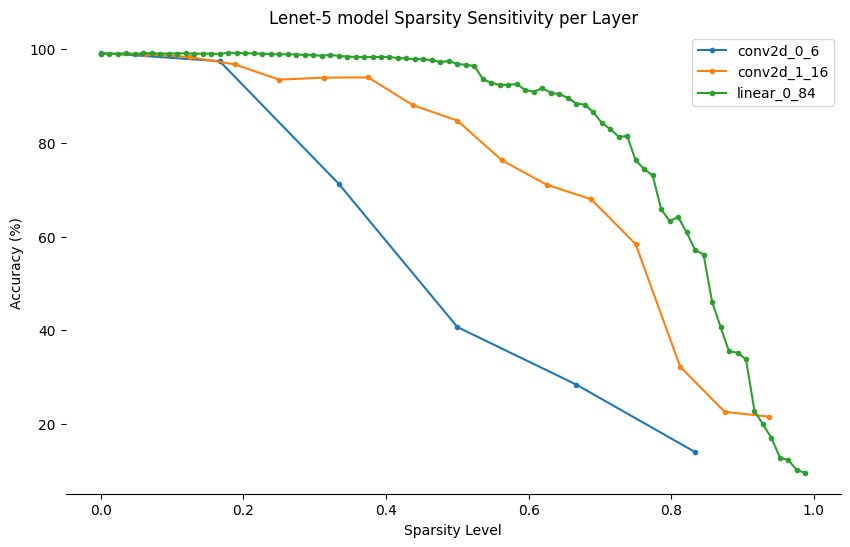

In [ ]:
plt.figure(figsize=(10, 6))
for layer, values in sensitivity['acc'].items():
    print(len(values), values)
    sparsity, acc = zip(*values)
    plt.plot(sparsity, acc, marker='.', label=layer+f"_{str(len(values))}")

plt.xlabel("Sparsity Level")
plt.ylabel("Accuracy (%)")
plt.title("Lenet-5 model Sparsity Sensitivity per Layer")
plt.legend()
plt.grid(False)

list(plt.gca().spines.values())[0].set_visible(False)
list(plt.gca().spines.values())[1].set_visible(False)
list(plt.gca().spines.values())[3].set_visible(False)

plt.savefig("Lenet-5 model Sparsity Sensitivity per Layer", dpi=300, bbox_inches="tight")
plt.show()


4

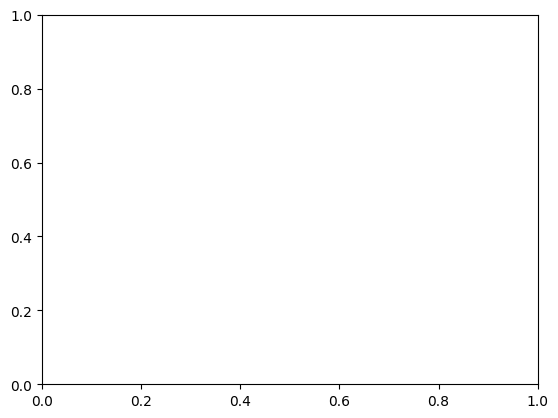

In [ ]:
len(plt.gca().spines.values())

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from itertools import product

# Your dataset
acc_data = {
    'conv2d_0': [(0.0, 99.22), (0.1667, 97.47), (0.3333, 71.31), (0.5, 40.65), (0.6667, 28.36), (0.8333, 13.94)],
    'conv2d_1': [(0.0, 99.05), (0.0625, 98.92), (0.125, 98.33), (0.1875, 96.8), (0.25, 93.52), (0.3125, 93.96),
                 (0.375, 94.0), (0.4375, 88.09), (0.5, 84.76), (0.5625, 76.28), (0.625, 71.09), (0.6875, 67.97),
                 (0.75, 58.37), (0.8125, 32.16), (0.875, 22.52), (0.9375, 21.5)],
    'linear_0': [
        (0.0, 99.05), (0.1667, 99.03), (0.3333, 98.61), (0.5, 96.88), (0.6667, 88.4),
        (0.75, 76.29), (0.8333, 57.14), (0.9167, 22.73), (1.0, 9.52)
    ]
}

# Build dataset as combinations of sparsities
X, y = [], []
for s0, _ in acc_data['conv2d_0']:
    for s1, _ in acc_data['conv2d_1']:
        for s2, acc in acc_data['linear_0']:
            # Features = sparsity levels
            X.append([s0, s1, s2])
            # Approx target = min accuracy among layers (proxy)
            y.append(acc)  

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Define MLP
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.layers(x)

model = MLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(500):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Example prediction
test_sparsity = torch.tensor([[0.5, 0.25, 0.33]])  # (conv2d_0, conv2d_1, linear_0)
pred_acc = model(test_sparsity).item()
print(f"Predicted Accuracy: {pred_acc:.2f}%")


Epoch 100, Loss: 5958.7373
Epoch 200, Loss: 4314.2148
Epoch 300, Loss: 2123.2832
Epoch 400, Loss: 1662.4471
Epoch 500, Loss: 1510.1141
Predicted Accuracy: 58.12%


In [ ]:
X, y

(tensor([[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1667],
         [0.0000, 0.0000, 0.3333],
         ...,
         [0.8333, 0.9375, 0.8333],
         [0.8333, 0.9375, 0.9167],
         [0.8333, 0.9375, 1.0000]]),
 tensor([[99.0500],
         [99.0300],
         [98.6100],
         [96.8800],
         [88.4000],
         [76.2900],
         [57.1400],
         [22.7300],
         [ 9.5200],
         [99.0500],
         [99.0300],
         [98.6100],
         [96.8800],
         [88.4000],
         [76.2900],
         [57.1400],
         [22.7300],
         [ 9.5200],
         [99.0500],
         [99.0300],
         [98.6100],
         [96.8800],
         [88.4000],
         [76.2900],
         [57.1400],
         [22.7300],
         [ 9.5200],
         [99.0500],
         [99.0300],
         [98.6100],
         [96.8800],
         [88.4000],
         [76.2900],
         [57.1400],
         [22.7300],
         [ 9.5200],
         [99.0500],
         [99.0300],
         [98.6

## Original Model


In [ ]:
lenet5_mcu_model = copy.deepcopy(lenet5_model)

evaluate_result = lenet5_mcu_model.evaluate(mnist_test_loader, {"acc":accuracy_fun}, device=DEVICE)
original_size = lenet5_mcu_model.get_size_in_bits()//8
print(f"The original model accuracy is {evaluate_result["acc"]*100:.2f}% with size {original_size} bytes.")

# lenet5_mcu_model.convert_to_c(var_name="lenet5_mcu_model", src_dir="./Arduino Nano 33 BLE/src/", include_dir="./Arduino Nano 33 BLE/include/")
lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/")

print(lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/"))
evaluate_result["acc"], original_size

100%|██████████| 313/313 [00:01<00:00, 239.41it/s]


The original model accuracy is 9915.00% with size 148240 bytes.
tensor([[-29.0016, -22.3953, -21.4715,  30.5191, -33.2081,   0.8119, -33.4459,
         -16.0511,  -6.0006,  -9.6175]], device='cuda:0')


(99.15, 148240)

In [ ]:
fused_lenet5_mcu_model = lenet5_mcu_model.fuse().to(DEVICE)

evaluate_result = fused_lenet5_mcu_model.evaluate(mnist_test_loader, {"acc":accuracy_fun}, device=DEVICE)
original_size = fused_lenet5_mcu_model.get_size_in_bits()//8
print(f"The original model accuracy is {evaluate_result["acc"]*100:.2f}% with size {original_size} bytes.")

# fused_lenet5_mcu_model.convert_to_c(var_name="lenet5_mcu_model", src_dir="./Arduino Nano 33 BLE/src/", include_dir="./Arduino Nano 33 BLE/include/")
fused_lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/")

print(fused_lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/"))
# print(fused_lenet5_mcu_model(lenet5_mcu_model.test_input[0].unsqueeze(dim=0).detach().clone()))
evaluate_result["acc"], original_size

100%|██████████| 313/313 [00:01<00:00, 231.04it/s]


The original model accuracy is 9911.00% with size 148088 bytes.
tensor([[-20.5041, -15.5337,  -1.6605,  -2.1882, -20.7473, -12.2588, -37.9503,
          14.2805, -11.3950,  -7.5340]], device='cuda:0')


(99.11, 148088)

In [ ]:
lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/"), 

(tensor([[-10.9922, -21.7113, -15.5854,   4.6235, -25.0249,   9.8817,  -9.2897,
          -15.5343,   0.8853,  -8.7347]], device='cuda:0'),)

In [ ]:
fused_lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/"), \
fused_lenet5_mcu_model(lenet5_mcu_model.test_input[0].unsqueeze(dim=0).detach().clone())

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
# compression_dict = lenet5_mcu_model.get_all_compression_hyperparameter()
# print(len(compression_dict))
# print((compression_dict)[0])
# lenet5_mcu_model.decode_compression_dict_hyperparameter(compression_dict[0])

In [ ]:
# sp = .9

s = QuantizationScheme.DYNAMIC
g = QuantizationGranularity.PER_TENSOR
b = 4
compression_config = {
    # "prune_channel" :{
    #     "sparsity" : sp,
    #     "metric" : "l2"
    # },
    "quantize" : {
        "scheme" : s,
        "granularity": g,
        "bitwidth" : b
    }
}

# compressed_lenet5_mcu_model = lenet5_mcu_model.init_compress(compression_config, input_shape=input_shape, calibration_data=next(iter(mnist_test_loader))[0].to(DEVICE))
compressed_lenet5_mcu_model = lenet5_mcu_model.fuse().init_compress(compression_config, input_shape=input_shape, calibration_data=next(iter(mnist_test_loader))[0].to(DEVICE))
before_acc = compressed_lenet5_mcu_model.evaluate(mnist_test_loader, {"acc":accuracy_fun}, device=DEVICE)["acc"]
# compressed_lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir="./HP HP Pavilion Laptop 15-cs3xxx/src/", include_dir="./HP HP Pavilion Laptop 15-cs3xxx/include/")
compressed_lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir=arduino_src_dir, include_dir=arduino_include_dir)
compressed_lenet5_mcu_model.convert_to_c(input_shape=input_shape, var_name="lenet5_mcu_model", src_dir=hp_src_dir, include_dir=hp_include_dir)

size = compressed_lenet5_mcu_model.get_size_in_bits()//8
print(f"Before training, sparsity = {sp}, scheme = {s.name}, granularity = {g.name}, bitwidth = {b} acc = {before_acc:.4f} size = {size/original_size*100:9.4f} {100 - size/original_size*100:9.4f}")

print(compressed_lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir=arduino_src_dir, include_dir=arduino_include_dir))
print(compressed_lenet5_mcu_model.test(device=DEVICE, var_name="lenet5_mcu_model", src_dir=hp_src_dir, include_dir=hp_include_dir))


100%|██████████| 313/313 [00:01<00:00, 171.57it/s]


NameError: name 'sp' is not defined